# Shared “base clean” + one split + EDA (for all models)

In [1]:
%pip install pandas numpy scikit-learn beautifulsoup4 lxml pyarrow transformers datasets accelerate


  Using cached pandas-2.3.2-cp310-cp310-win_amd64.whl (11.3 MB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Using cached scikit_learn-1.7.1-cp310-cp310-win_amd64.whl (8.9 MB)
     ---------------------------------------- 0.0/105.1 kB ? eta -:--:--
     -------------------------------------- 105.1/105.1 kB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     --------- ------------------------------ 1.0/4.0 MB 31.1 MB/s eta 0:00:01
     ------------------------ --------------- 2.5/4.0 MB 40.0 MB/s eta 0:00:01
     ------------------------------ --------- 3.1/4.0 MB 28.4 MB/s eta 0:00:01
     ---------------------------------------  4.0/4.0 MB 32.1 MB/s eta 0:00:01
     ---------------------------------------- 4.0/4.0 MB 28.7 MB/s eta 0:00:00
  Using cached pyarrow-21.0.0-cp310-cp310-win_amd64.whl (26.2 MB)
     ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
     ----- ---------------------------------- 


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128Note: you may need to restart the kernel to use updated packages.

  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cu128/torchvision-0.23.0%2Bcu128-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cu128/torch-2.8.0%2Bcu128-cp310-cp310-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu128/torch-2.8.0%2Bcu128-cp310-cp310-win_amd64.whl.metadata (29 kB)
  Obtaining dependency information for pillow!=8.3.*,>=5.3.0 from https://download.pytorch.org/whl/pillow-11.0.0-cp310-cp310-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/pillow-11.0.0-cp310-cp310-win_amd64.whl.metadata (9.3 kB)
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   -- ------------------------------------- 0.6/7.5 MB 11.5 MB/s eta 0:00:01
   ------ --------------------------------- 1.3/7.5 MB 16


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ------- -------------------------------- 0.7/3.5 GB 32.8 MB/s eta 0:01:25
   ------- -------------------------------- 0.7/3.5 GB 36.4 MB/s eta 0:01:17
   ------- -------------------------------- 0.7/3.5 GB 34.4 MB/s eta 0:01:21
   ------- -------------------------------- 0.7/3.5 GB 34.4 MB/s eta 0:01:21
   ------- -------------------------------- 0.7/3.5 GB 36.4 MB/s eta 0:01:17
   ------- -------------------------------- 0.7/3.5 GB 38.5 MB/s eta 0:01:13
   ------- -------------------------------- 0.7/3.5 GB 38.6 MB/s eta 0:01:12
   ------- -------------------------------- 0.7/3.5 GB 34.4 MB/s eta 0:01:21
   ------- -------------------------------- 0.7/3.5 GB 36.4 MB/s eta 0:01:17
   -------- ------------------------------- 0.7/3.5 GB 36.4 MB/s eta 0:01:17
   -------- ------------------------------- 0.7/3.5 GB 32.7 MB/s eta 0:01:25
   -------- ------------------------------- 0.7/3.5 GB 38.6 MB/s eta 0:01:12
   -------- ------------------------------- 0.7/3.5 GB 38.6 MB/s eta 0:01:12

In [1]:
import torch

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA device memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("CUDA is not available - PyTorch will use CPU")

# Test tensor creation on GPU
if torch.cuda.is_available():
    x = torch.randn(3, 3).cuda()
    print(f"Test tensor device: {x.device}")
    print("✅ GPU tensor creation successful")

CUDA available: True
CUDA version: 12.8
PyTorch version: 2.8.0+cu128
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA device memory: 6.0 GB
Test tensor device: cuda:0
✅ GPU tensor creation successful


In [2]:
IN_PATH  = "dataset/IMDB Dataset.csv"      # Kaggle file
OUT_PATH = "dataset/imdb_clean_split.csv"  # Shared artifact

In [ ]:
# --- Setup ---
import re, unicodedata, hashlib, html, string, pandas as pd, numpy as np
from bs4 import BeautifulSoup

def clean_text(x):
    if not isinstance(x, str):
        return ""
    # Unescape & strip HTML
    x = html.unescape(x)
    x = BeautifulSoup(x, "lxml").get_text(separator=" ")

    # Unicode normalize + unify curly quotes to straight ones
    x = unicodedata.normalize("NFKC", x)
    x = x.replace("“", "'").replace("”", "'").replace("‘", "'").replace("’", "'").replace('"', "'")

    # Neutralize obvious artifacts
    x = re.sub(r"(https?://\S+)|(\w+\.\w+/\S+)", " ", x)
    x = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", " ", x)

    # runs of 2+ asterisks → single *
    x = re.sub(r"\*{2,}", "*", x)

    # collapse any run of -, – or — to a single em dash, with spacing
    x = re.sub(r"\s*[-–—]{2,}\s*", " — ", x)

    # "" → "   and   '' → '
    x = re.sub(r'([\'\"])\1+', r'\1', x)  # collapse immediate repeats
    # also clean cases with whitespace between repeated quotes: "  " → "
    x = re.sub(r'([\'"])\s+\1', r'\1', x)

    # cap !!!!! or ????? at two; dots at an ellipsis
    x = re.sub(r"([!?])\1{2,}", r"\1\1", x)   # keep at most two
    x = re.sub(r"\.{3,}", "…", x)

    # 5) Remove control chars & collapse whitespace
    x = re.sub(r"[\u0000-\u001F\u007F]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

df = pd.read_csv(IN_PATH)  # columns: review, sentiment
df["review_clean"] = df["review"].apply(clean_text)
df["label"] = (df["sentiment"].str.lower() == "positive").astype(int)
df

,review,sentiment,review_clean,label
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Petter Mattei's 'Love in the Time of Money' is...,1
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,negative,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,negative,I'm going to have to disagree with the previou...,0


In [4]:
# drop null/empty data first
df = df.dropna(subset=['review_clean']).copy()  # drop rows where review_clean is null
# deduplicate (after cleaning) - keep first occurrence
def row_key(s): return hashlib.sha1(s.encode("utf-8")).hexdigest()
df["dup_key"] = df["review_clean"].apply(row_key)
df = df.drop_duplicates(subset=["dup_key"], keep='first').drop(columns=["dup_key"]).reset_index(drop=True)
df

,review,sentiment,review_clean,label
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Petter Mattei's 'Love in the Time of Money' is...,1
...,...,...,...,...
49573,I thought this movie did a down right good job...,positive,I thought this movie did a down right good job...,1
49574,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49575,I am a Catholic taught in parochial elementary...,negative,I am a Catholic taught in parochial elementary...,0
49576,I'm going to have to disagree with the previou...,negative,I'm going to have to disagree with the previou...,0


In [5]:
from sklearn.model_selection import train_test_split

X = df["review_clean"].values
y = df["label"].values

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Second split: from the 80%, split into 70% train (87.5% of temp) and 10% val (12.5% of temp)
# 0.125 = 10% / 80% (to get 10% of original data)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)

# Create split column
df["split"] = "train"  # default
df.loc[df["review_clean"].isin(X_test), "split"] = "test"
df.loc[df["review_clean"].isin(X_val), "split"] = "val"

# basic EDA
print(df["split"].value_counts())
print(df["label"].value_counts())

df["n_chars"] = df["review_clean"].str.len()
df["n_words"] = df["review_clean"].str.split().apply(len)
print(df[["n_chars","n_words"]].describe(percentiles=[.5,.75,.9,.95,.99]))

df = df.rename(columns={"review_clean":"text"})
df[["text","label","split"]].to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)

split
train    34704
test      9916
val       4958
Name: count, dtype: int64
label
1    24882
0    24696
Name: count, dtype: int64
            n_chars       n_words
count  49578.000000  49578.000000
mean    1286.472710    229.274013
std      972.892891    169.952820
min       32.000000      4.000000
50%      954.000000    172.000000
75%     1560.000000    278.000000
90%     2532.000000    448.000000
95%     3334.000000    585.150000
99%     5100.000000    898.230000
max    13593.000000   2459.000000
Saved: dataset/imdb_clean_split.csv


# Check for “lengthy” reviews (DistilBERT perspective)

In [7]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

df = pd.read_csv(OUT_PATH)
# compute token lengths without truncation (add_special_tokens=True)
def token_len(t): 
    return len(tok(t, truncation=False, add_special_tokens=True)["input_ids"])

# sample for speed if needed:
# lens = df["review_clean"].sample(5000, random_state=0).apply(token_len)
lens = df["text"].apply(token_len)

thr = [128, 256, 384, 512]
for t in thr:
    pct = (lens > t).mean()*100
    print(f"> {t} tokens: {pct:.2f}%")

print("Median:", np.median(lens), "95th:", np.percentile(lens, 95))

Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


> 128 tokens: 87.46%
> 256 tokens: 40.28%
> 384 tokens: 21.87%
> 512 tokens: 12.70%
Median: 219.0 95th: 750.0


# DistilBERT training

## Without sliding windows

In [8]:
import numpy as np, pandas as pd, torch
import os, json
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

SEED = 42
MODEL = "distilbert-base-uncased"
MODEL_OUT = "models/distilbert/standard"
MAX_LEN = 512
BATCH = 16
EPOCHS = 5
LR = 2e-5

raw = pd.read_csv(OUT_PATH)
tok = AutoTokenizer.from_pretrained(MODEL)

def tokenize_no_slide(examples):
    return tok(examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

# build datasets
def subset(split):
    df = raw[raw["split"]==split].rename(columns={"review_clean":"text"})
    return Dataset.from_pandas(df[["text","label"]], preserve_index=False)

ds = {"train": subset("train"), "val": subset("val"), "test": subset("test")}
ds["train"] = ds["train"].map(tokenize_no_slide, batched=True)
ds["val"]   = ds["val"].map(tokenize_no_slide,   batched=True)
ds["test"]  = ds["test"].map(tokenize_no_slide,  batched=True)
cols = ["input_ids","attention_mask","label"]
for k in ds: ds[k].set_format(type="torch", columns=cols)

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    y = p.label_ids
    return {
        "accuracy": accuracy_score(y, preds),
        "f1": f1_score(y, preds, average="weighted"),
        "precision": precision_score(y, preds, average="weighted"),
        "recall": recall_score(y, preds, average="weighted"),
    }

args = TrainingArguments(
    output_dir=MODEL_OUT,
    seed=SEED,
    learning_rate=LR,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    weight_decay=0.01,
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["val"],
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok),
    compute_metrics=compute_metrics
)

trainer.train()
print(trainer.evaluate(ds["test"]))

os.makedirs(MODEL_OUT, exist_ok=True)

# Save model & tokenizer
trainer.save_model(MODEL_OUT)          # saves model + config
tok.save_pretrained(MODEL_OUT)         # saves tokenizer files

# (Optional but nice) persist label maps explicitly
with open(os.path.join(MODEL_OUT, "label_map.json"), "w") as f:
    json.dump({
        "id2label": model.config.id2label,
        "label2id": model.config.label2id
    }, f, indent=2)

import pandas as pd
pd.DataFrame(trainer.state.log_history).to_csv(f"{MODEL_OUT}/train_log.csv", index=False)

Map: 100%|██████████| 9916/9916 [00:03<00:00, 2918.84 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_16320\411848664.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.200500,0.316231,0.893505,0.892846,0.903968,0.893505
2,0.163700,0.217965,0.933844,0.933829,0.934164,0.933844
3,0.094800,0.281230,0.934853,0.934853,0.934853,0.934853
4,0.046500,0.341508,0.935054,0.935055,0.935062,0.935054
5,0.021000,0.342657,0.937071,0.937055,0.937434,0.937071


{'eval_loss': 0.3360878527164459, 'eval_accuracy': 0.9378781766841469, 'eval_f1': 0.9378714382465183, 'eval_precision': 0.9380058504971102, 'eval_recall': 0.9378781766841469, 'eval_runtime': 337.2708, 'eval_samples_per_second': 29.401, 'eval_steps_per_second': 1.838, 'epoch': 5.0}


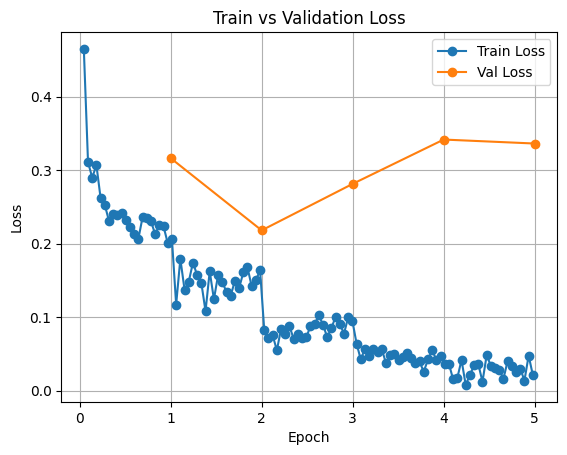

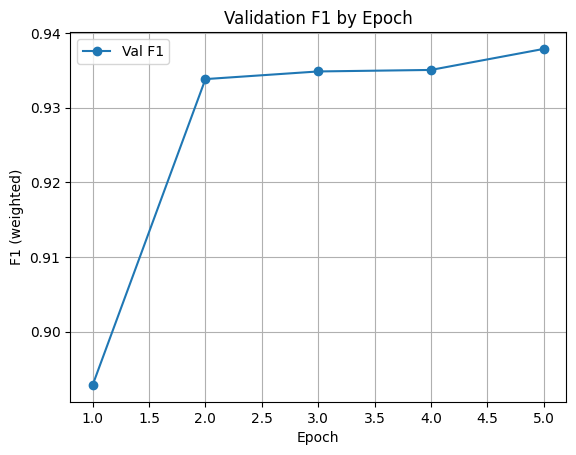

Suggested stop at epoch 3 (first plateau: ΔF1 < 0.0005).
Best F1: epoch 5 = 0.937871


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

LOG_PATH = "models/distilbert/standard/train_log.csv"

df = pd.read_csv(LOG_PATH)

# Extract per-epoch series from HF Trainer logs
# Train loss: many rows per epoch; we take the LAST logged loss in each epoch.
train_loss = (df[df["loss"].notna()]
              .groupby("epoch", as_index=True)["loss"]
              .last())

# Val metrics: one row per eval; keep last per epoch in case of duplicates.
val_rows = df[df["eval_loss"].notna()].drop_duplicates("epoch", keep="last").set_index("epoch")
val_loss = val_rows["eval_loss"]
val_f1   = val_rows["eval_f1"] if "eval_f1" in val_rows else None

# ---- Plot 1: Loss curves ----
plt.figure()
train_loss.sort_index().plot(marker="o", label="Train Loss")
val_loss.sort_index().plot(marker="o", label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train vs Validation Loss")
plt.grid(True); plt.legend()
plt.show()

# ---- Plot 2: Validation F1 ----
if val_f1 is not None:
    plt.figure()
    val_f1.sort_index().plot(marker="o", label="Val F1")
    plt.xlabel("Epoch"); plt.ylabel("F1 (weighted)"); plt.title("Validation F1 by Epoch")
    plt.grid(True); plt.legend()
    plt.show()

# ---- Pick first plateau epoch ----
def pick_plateau_epoch(f1_series, min_delta=5e-4, patience=1):
    """Return the first epoch where improvements fall below min_delta for `patience` consecutive steps.
       If no plateau, return epoch of max F1."""
    s = f1_series.sort_index()
    epochs = s.index.to_list()
    best_epoch = int(s.idxmax())
    streak = 0
    for prev, cur in zip(epochs[:-1], epochs[1:]):
        gain = s.loc[cur] - s.loc[prev]
        if gain < min_delta:
            streak += 1
            if streak >= patience:
                return int(prev)  # plateau detected at prev
        else:
            streak = 0
    return best_epoch  # fallback

if val_f1 is not None:
    plateau = pick_plateau_epoch(val_f1, min_delta=5e-4, patience=1)
    print(f"Suggested stop at epoch {plateau} (first plateau: ΔF1 < 0.0005).")
    print(f"Best F1: epoch {int(val_f1.idxmax())} = {val_f1.max():.6f}")
else:
    print("No eval F1 found in log; make sure compute_metrics returns 'f1' and you log 'eval_f1'.")

## Load the epoch-3 checkpoint

In [10]:
import os, pandas as pd, glob
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_OUT = "models/distilbert/standard"  # your run folder

# 1) Read the log to get the 'step' used for epoch 3's eval/save
log = pd.read_csv(f"{MODEL_OUT}/train_log.csv")  # you saved this earlier
# keep rows that have eval metrics (1 per epoch typically)
eval_rows = log[log["eval_loss"].notna()].copy()
# select the epoch 3 row (epoch is float in logs)
row_e3 = eval_rows.loc[(eval_rows["epoch"].round().astype(int) == 3)].tail(1)
assert not row_e3.empty, "Epoch 3 not found in log."
step_e3 = int(row_e3["step"].iloc[0])

ckpt_dir = os.path.join(MODEL_OUT, f"checkpoint-{step_e3}")
print("Epoch-3 checkpoint:", ckpt_dir, os.path.exists(ckpt_dir))

# 2) Load tokenizer + model from that checkpoint
tok = AutoTokenizer.from_pretrained(ckpt_dir)
model = AutoModelForSequenceClassification.from_pretrained(ckpt_dir)

# 3) (Optional) export to a clean folder for inference
EXPORT = "models/distilbert/epoch3-export"
os.makedirs(EXPORT, exist_ok=True)
model.save_pretrained(EXPORT)
tok.save_pretrained(EXPORT)
print("Exported epoch-3 model to:", EXPORT)

Epoch-3 checkpoint: models/distilbert/standard\checkpoint-6507 True
Exported epoch-3 model to: models/distilbert/epoch3-export


In [12]:
import os, pandas as pd, numpy as np, torch
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, Trainer)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# ---- SET THESE ----
CKPT_DIR = "models/distilbert/standard/epoch3-export"
CSV      = "dataset/imdb_clean_split.csv"
MAX_LEN  = 512

# Load tokenizer/model (skip if already in memory)
try:
    tok
    model
except NameError:
    tok = AutoTokenizer.from_pretrained(CKPT_DIR)
    model = AutoModelForSequenceClassification.from_pretrained(CKPT_DIR)

# Build the same VALIDATION dataset
df = pd.read_csv(CSV)
val_df = df[df["split"] == "val"][["text","label"]]
val_ds = Dataset.from_pandas(val_df, preserve_index=False)

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

val_ds = val_ds.map(tokenize, batched=True)
val_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])

# Metrics
def compute_metrics(p):
    logits = p.predictions
    y = p.label_ids
    preds = logits.argmax(-1)
    prob_pos = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    return {
        "accuracy":  accuracy_score(y, preds),
        "f1":        f1_score(y, preds, average="weighted"),
        "precision": precision_score(y, preds, average="weighted"),
        "recall":    recall_score(y, preds, average="weighted"),
    }

trainer = Trainer(
    model=model,
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok),
    compute_metrics=compute_metrics
)

# ---- Evaluate on VAL ----
eval_res = trainer.evaluate(val_ds)
print("Epoch-3 checkpoint on VAL:", eval_res)

# ---- Optional: verify against the logged epoch-3 numbers ----
log_path = os.path.join(os.path.dirname(CKPT_DIR), "train_log.csv")
if os.path.exists(log_path):
    log = pd.read_csv(log_path)
    e3 = log[(log["epoch"].round().astype(int) == 3) & log["eval_f1"].notna()].tail(1)
    if not e3.empty:
        logged_f1 = float(e3["eval_f1"].iloc[0])
        print(f"Logged epoch-3 eval_f1: {logged_f1:.6f}")
        print(f"Recomputed eval_f1:      {eval_res['eval_f1']:.6f}")
        print(f"Δ = {abs(logged_f1 - eval_res['eval_f1']):.6g} (should be ~0)")

Map: 100%|██████████| 4958/4958 [00:01<00:00, 2674.39 examples/s]
C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_16320\689965534.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch-3 checkpoint on VAL: {'eval_loss': 0.2812303602695465, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.9348527632109722, 'eval_f1': 0.9348528082653484, 'eval_precision': 0.9348529293810695, 'eval_recall': 0.9348527632109722, 'eval_runtime': 80.3594, 'eval_samples_per_second': 61.698, 'eval_steps_per_second': 7.715}
Logged epoch-3 eval_f1: 0.934853
Recomputed eval_f1:      0.934853
Δ = 0 (should be ~0)


## With sliding windows

In [ ]:
import numpy as np, pandas as pd, torch
import os, json
from collections import OrderedDict
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# -------------------
# Config
# -------------------
SEED = 42
MODEL = "distilbert-base-uncased"
MODEL_OUT = "models/distilbert/slide"
MAX_LEN = 512
STRIDE  = 256
MAX_WINDOWS = 4
BATCH = 16
EPOCHS = 5
LR = 2e-5

# Your cleaned+split CSV
raw = pd.read_csv(OUT_PATH)  # expects review_clean, label, split
tok = AutoTokenizer.from_pretrained(MODEL)

# -------------------
# Sliding-window tokenization
# -------------------
def tokenize_with_slide(batch):
    enc = tok(
        batch["text"],
        truncation=True,
        max_length=MAX_LEN,
        stride=STRIDE,
        return_overflowing_tokens=True,
        padding=False
    )
    # Map windows back to original items in this batch
    of = enc.pop("overflow_to_sample_mapping")

    # Replicate labels/doc_id per window
    labels  = [batch["label"][i]  for i in of]
    doc_idx = [batch["doc_id"][i] for i in of]

    # Optional: cap number of windows per document
    if MAX_WINDOWS is not None:
        keep = []
        seen = {}
        for d in doc_idx:
            seen[d] = seen.get(d, 0) + 1
            keep.append(seen[d] <= MAX_WINDOWS)
        for k in list(enc.keys()):
            enc[k] = [v for v, ok in zip(enc[k], keep) if ok]
        labels  = [v for v, ok in zip(labels,  keep) if ok]
        doc_idx = [v for v, ok in zip(doc_idx, keep) if ok]

    enc["label"] = labels
    enc["doc_idx"] = doc_idx  # keep for doc-level aggregation later
    return enc

def make_ds(split):
    df = raw[raw["split"]==split].reset_index()
    df = df.rename(columns={"index":"doc_id"})  # stable ID per document within split
    ds = Dataset.from_pandas(df[["text","label","doc_id"]], preserve_index=False)
    ds = ds.map(tokenize_with_slide, batched=True, remove_columns=["text","label","doc_id"])
    # Only pass model inputs to the model; keep doc_idx in the dataset for later aggregation
    ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
    return ds, df[["doc_id","label"]]  # return the frame to recover true labels per doc

ds = {}
frame = {}
for sp in ["train","val","test"]:
    ds[sp], frame[sp] = make_ds(sp)

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

# -------------------
# Chunk-level metrics (used during training/early stopping)
# -------------------
def compute_metrics_chunk(p):
    preds = p.predictions.argmax(-1)
    y = p.label_ids
    return {
        "accuracy":  accuracy_score(y, preds),
        "f1":        f1_score(y, preds, average="weighted"),
        "precision": precision_score(y, preds, average="weighted"),
        "recall":    recall_score(y, preds, average="weighted"),
    }

args = TrainingArguments(
    output_dir=MODEL_OUT,
    seed=SEED,
    learning_rate=LR,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    weight_decay=0.01,
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["val"],
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok),
    compute_metrics=compute_metrics_chunk
)

trainer.train()

Map: 100%|██████████| 9916/9916 [00:03<00:00, 3030.57 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_16320\271931538.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.216100,0.223906,0.924322,0.924173,0.926837,0.924322
2,0.150700,0.231995,0.931993,0.931994,0.932008,0.931993
3,0.064200,0.344889,0.931311,0.931305,0.931829,0.931311
4,0.056700,0.364946,0.933015,0.932997,0.933223,0.933015
5,0.024700,0.392984,0.933867,0.933867,0.933867,0.933867


TypeError: iteration over a 0-d array

In [15]:
# -------------------
# Doc-level evaluation helper (mean of window logits)
# -------------------
def eval_doc_level(split):
    # 1) Chunk-level predictions in dataset order
    pred = trainer.predict(ds[split])
    logits = torch.tensor(pred.predictions)
    probs  = torch.softmax(logits, dim=1).numpy()  # [num_windows, 2]

    # 2) Get doc_idx as a 1-D numpy array
    doc_idx = np.asarray(ds[split].with_format("numpy")["doc_idx"]).reshape(-1)

    # Sanity check
    assert probs.shape[0] == doc_idx.shape[0], f"len(probs)={probs.shape[0]} vs len(doc_idx)={doc_idx.shape[0]}"

    # 3) Preserve first-seen document order
    order = []
    seen = set()
    for d in doc_idx:
        if d not in seen:
            seen.add(d)
            order.append(int(d))

    # 4) Aggregate window probs per document (mean of logits/probs; here probs)
    agg_probs = []
    for d in order:
        m = (doc_idx == d)
        agg_probs.append(probs[m].mean(axis=0))
    agg_probs = np.vstack(agg_probs)

    # 5) True labels in same order
    lab_map = dict(zip(frame[split]["doc_id"], frame[split]["label"]))
    y_true = np.array([lab_map[d] for d in order])
    y_pred = agg_probs.argmax(axis=1)

    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "f1":        f1_score(y_true, y_pred, average="weighted"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall":    recall_score(y_true, y_pred, average="weighted"),
        "num_docs":  len(order),
    }

print("VAL (doc-level): ", eval_doc_level("val"))
print("TEST (doc-level):", eval_doc_level("test"))

# -------------------
# Save best model + tokenizer
# -------------------
os.makedirs(MODEL_OUT, exist_ok=True)
trainer.save_model(MODEL_OUT)
tok.save_pretrained(MODEL_OUT)

with open(os.path.join(MODEL_OUT, "label_map.json"), "w") as f:
    json.dump({
        "id2label": model.config.id2label,
        "label2id": model.config.label2id
    }, f, indent=2)

# Learning-curve log
pd.DataFrame(trainer.state.log_history).to_csv(f"{MODEL_OUT}/train_log.csv", index=False)

VAL (doc-level):  {'accuracy': 0.9400968132311416, 'f1': 0.9400965329821437, 'precision': 0.940098164971703, 'recall': 0.9400968132311416, 'num_docs': 4958}


TEST (doc-level): {'accuracy': 0.9407018959257766, 'f1': 0.9407020406626864, 'precision': 0.9407194062128496, 'recall': 0.9407018959257766, 'num_docs': 9916}


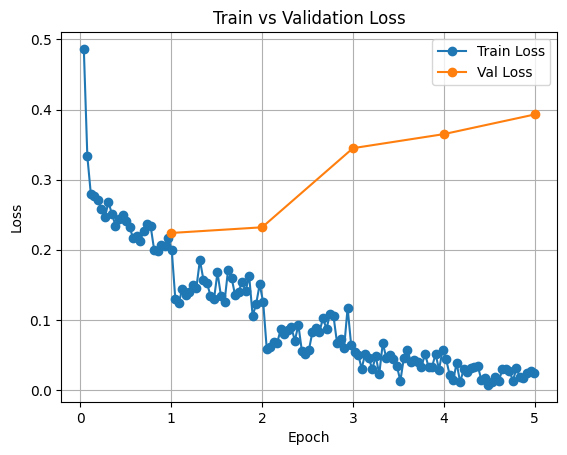

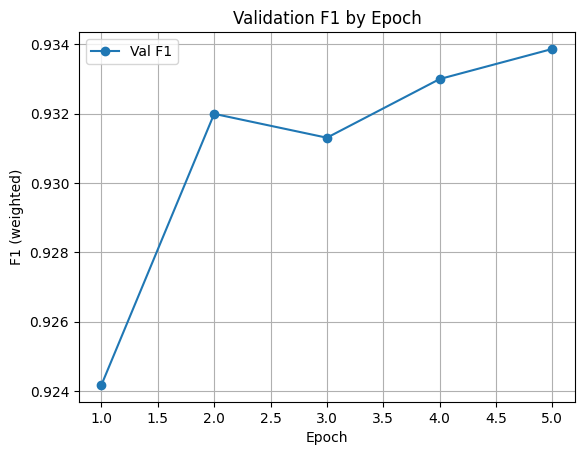

Suggested stop at epoch 2 (first plateau: ΔF1 < 0.0005).
Best F1: epoch 5 = 0.933867


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

LOG_PATH = "models/distilbert/slide/train_log.csv"

df = pd.read_csv(LOG_PATH)

# Extract per-epoch series from HF Trainer logs
# Train loss: many rows per epoch; we take the LAST logged loss in each epoch.
train_loss = (df[df["loss"].notna()]
              .groupby("epoch", as_index=True)["loss"]
              .last())

# Val metrics: one row per eval; keep last per epoch in case of duplicates.
val_rows = df[df["eval_loss"].notna()].drop_duplicates("epoch", keep="last").set_index("epoch")
val_loss = val_rows["eval_loss"]
val_f1   = val_rows["eval_f1"] if "eval_f1" in val_rows else None

# ---- Plot 1: Loss curves ----
plt.figure()
train_loss.sort_index().plot(marker="o", label="Train Loss")
val_loss.sort_index().plot(marker="o", label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train vs Validation Loss")
plt.grid(True); plt.legend()
plt.show()

# ---- Plot 2: Validation F1 ----
if val_f1 is not None:
    plt.figure()
    val_f1.sort_index().plot(marker="o", label="Val F1")
    plt.xlabel("Epoch"); plt.ylabel("F1 (weighted)"); plt.title("Validation F1 by Epoch")
    plt.grid(True); plt.legend()
    plt.show()

# ---- Pick first plateau epoch ----
def pick_plateau_epoch(f1_series, min_delta=5e-4, patience=1):
    """Return the first epoch where improvements fall below min_delta for `patience` consecutive steps.
       If no plateau, return epoch of max F1."""
    s = f1_series.sort_index()
    epochs = s.index.to_list()
    best_epoch = int(s.idxmax())
    streak = 0
    for prev, cur in zip(epochs[:-1], epochs[1:]):
        gain = s.loc[cur] - s.loc[prev]
        if gain < min_delta:
            streak += 1
            if streak >= patience:
                return int(prev)  # plateau detected at prev
        else:
            streak = 0
    return best_epoch  # fallback

if val_f1 is not None:
    plateau = pick_plateau_epoch(val_f1, min_delta=5e-4, patience=1)
    print(f"Suggested stop at epoch {plateau} (first plateau: ΔF1 < 0.0005).")
    print(f"Best F1: epoch {int(val_f1.idxmax())} = {val_f1.max():.6f}")
else:
    print("No eval F1 found in log; make sure compute_metrics returns 'f1' and you log 'eval_f1'.")

## Load 2nd epoch

In [19]:
import os, pandas as pd, glob
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_OUT = "models/distilbert/slide"

# 1) Read the log to get the 'step' used for epoch 3's eval/save
log = pd.read_csv(f"{MODEL_OUT}/train_log.csv")  # you saved this earlier
# keep rows that have eval metrics (1 per epoch typically)
eval_rows = log[log["eval_loss"].notna()].copy()
# select the epoch 2 row (epoch is float in logs)
row_e2 = eval_rows.loc[(eval_rows["epoch"].round().astype(int) == 2)].tail(1)
assert not row_e2.empty, "Epoch 2 not found in log."
step_e2 = int(row_e2["step"].iloc[0])

ckpt_dir = os.path.join(MODEL_OUT, f"checkpoint-{step_e2}")
print("Epoch-2 checkpoint:", ckpt_dir, os.path.exists(ckpt_dir))

# 2) Load tokenizer + model from that checkpoint
tok = AutoTokenizer.from_pretrained(ckpt_dir)
model = AutoModelForSequenceClassification.from_pretrained(ckpt_dir)

# 3) (Optional) export to a clean folder for inference
EXPORT = "models/distilbert/epoch2-export-slide"
os.makedirs(EXPORT, exist_ok=True)
model.save_pretrained(EXPORT)
tok.save_pretrained(EXPORT)
print("Exported epoch-2 model to:", EXPORT)

Epoch-2 checkpoint: models/distilbert/slide\checkpoint-5168 False


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': 'models/distilbert/slide\checkpoint-5168'. Use `repo_type` argument if needed.

## retrain model with 2 epoch (sliding window)

In [20]:
import numpy as np, pandas as pd, torch
import os, json
from collections import OrderedDict
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# -------------------
# Config
# -------------------
SEED = 42
MODEL = "distilbert-base-uncased"
MODEL_OUT = "models/distilbert/slide-epoch2"
MAX_LEN = 512
STRIDE  = 256
MAX_WINDOWS = 4
BATCH = 16
EPOCHS = 2
LR = 2e-5

# Your cleaned+split CSV
raw = pd.read_csv(OUT_PATH)  # expects review_clean, label, split
tok = AutoTokenizer.from_pretrained(MODEL)

# -------------------
# Sliding-window tokenization
# -------------------
def tokenize_with_slide(batch):
    enc = tok(
        batch["text"],
        truncation=True,
        max_length=MAX_LEN,
        stride=STRIDE,
        return_overflowing_tokens=True,
        padding=False
    )
    # Map windows back to original items in this batch
    of = enc.pop("overflow_to_sample_mapping")

    # Replicate labels/doc_id per window
    labels  = [batch["label"][i]  for i in of]
    doc_idx = [batch["doc_id"][i] for i in of]

    # Optional: cap number of windows per document
    if MAX_WINDOWS is not None:
        keep = []
        seen = {}
        for d in doc_idx:
            seen[d] = seen.get(d, 0) + 1
            keep.append(seen[d] <= MAX_WINDOWS)
        for k in list(enc.keys()):
            enc[k] = [v for v, ok in zip(enc[k], keep) if ok]
        labels  = [v for v, ok in zip(labels,  keep) if ok]
        doc_idx = [v for v, ok in zip(doc_idx, keep) if ok]

    enc["label"] = labels
    enc["doc_idx"] = doc_idx  # keep for doc-level aggregation later
    return enc

def make_ds(split):
    df = raw[raw["split"]==split].reset_index()
    df = df.rename(columns={"index":"doc_id"})  # stable ID per document within split
    ds = Dataset.from_pandas(df[["text","label","doc_id"]], preserve_index=False)
    ds = ds.map(tokenize_with_slide, batched=True, remove_columns=["text","label","doc_id"])
    # Only pass model inputs to the model; keep doc_idx in the dataset for later aggregation
    ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
    return ds, df[["doc_id","label"]]  # return the frame to recover true labels per doc

ds = {}
frame = {}
for sp in ["train","val","test"]:
    ds[sp], frame[sp] = make_ds(sp)

model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

# -------------------
# Chunk-level metrics (used during training/early stopping)
# -------------------
def compute_metrics_chunk(p):
    preds = p.predictions.argmax(-1)
    y = p.label_ids
    return {
        "accuracy":  accuracy_score(y, preds),
        "f1":        f1_score(y, preds, average="weighted"),
        "precision": precision_score(y, preds, average="weighted"),
        "recall":    recall_score(y, preds, average="weighted"),
    }

args = TrainingArguments(
    output_dir=MODEL_OUT,
    seed=SEED,
    learning_rate=LR,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    weight_decay=0.01,
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["val"],
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok),
    compute_metrics=compute_metrics_chunk
)

trainer.train()

# -------------------
# Doc-level evaluation helper (mean of window logits)
# -------------------
def eval_doc_level(split):
    # 1) Chunk-level predictions in dataset order
    pred = trainer.predict(ds[split])
    logits = torch.tensor(pred.predictions)
    probs  = torch.softmax(logits, dim=1).numpy()  # [num_windows, 2]

    # 2) Get doc_idx as a 1-D numpy array
    doc_idx = np.asarray(ds[split].with_format("numpy")["doc_idx"]).reshape(-1)

    # Sanity check
    assert probs.shape[0] == doc_idx.shape[0], f"len(probs)={probs.shape[0]} vs len(doc_idx)={doc_idx.shape[0]}"

    # 3) Preserve first-seen document order
    order = []
    seen = set()
    for d in doc_idx:
        if d not in seen:
            seen.add(d)
            order.append(int(d))

    # 4) Aggregate window probs per document (mean of logits/probs; here probs)
    agg_probs = []
    for d in order:
        m = (doc_idx == d)
        agg_probs.append(probs[m].mean(axis=0))
    agg_probs = np.vstack(agg_probs)

    # 5) True labels in same order
    lab_map = dict(zip(frame[split]["doc_id"], frame[split]["label"]))
    y_true = np.array([lab_map[d] for d in order])
    y_pred = agg_probs.argmax(axis=1)

    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "f1":        f1_score(y_true, y_pred, average="weighted"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall":    recall_score(y_true, y_pred, average="weighted"),
        "num_docs":  len(order),
    }

print("VAL (doc-level): ", eval_doc_level("val"))
print("TEST (doc-level):", eval_doc_level("test"))

# -------------------
# Save best model + tokenizer
# -------------------
os.makedirs(MODEL_OUT, exist_ok=True)
trainer.save_model(MODEL_OUT)
tok.save_pretrained(MODEL_OUT)

with open(os.path.join(MODEL_OUT, "label_map.json"), "w") as f:
    json.dump({
        "id2label": model.config.id2label,
        "label2id": model.config.label2id
    }, f, indent=2)

# Learning-curve log
pd.DataFrame(trainer.state.log_history).to_csv(f"{MODEL_OUT}/train_log.csv", index=False)

Map: 100%|██████████| 9916/9916 [00:03<00:00, 3129.32 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_16320\3464818734.py:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.206100,0.212870,0.923483,0.923422,0.925622,0.923483
2,0.142800,0.226649,0.931493,0.931467,0.931824,0.931493


VAL (doc-level):  {'accuracy': 0.9372730939895119, 'f1': 0.9372535323202801, 'precision': 0.9377104604071463, 'recall': 0.9372730939895119, 'num_docs': 4958}


TEST (doc-level): {'accuracy': 0.9392900363049617, 'f1': 0.9392802985754299, 'precision': 0.939493544259792, 'recall': 0.9392900363049617, 'num_docs': 9916}


# Load model and run inference (no sliding window)

In [21]:
import torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def load_model(model_dir):
    tok = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir).to(DEVICE)
    id2label = model.config.id2label  # e.g., {0: 'NEGATIVE', 1: 'POSITIVE'} or keys as strings
    return tok, model, id2label

def _idx_to_label(i, id2label):
    return id2label[i] if i in id2label else id2label[str(i)]

def predict_batch(texts, tok, model, max_len=256, batch_size=32):
    all_preds, all_probs = [], []
    model.eval()
    for start in range(0, len(texts), batch_size):
        chunk = texts[start:start+batch_size]
        enc = tok(chunk, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
            probs  = torch.softmax(logits, dim=-1).cpu().numpy()
            preds  = probs.argmax(axis=-1)
        all_preds.extend(preds.tolist())
        all_probs.extend(probs.tolist())
    return np.array(all_preds), np.array(all_probs)

def predict_one(text, tok, model, max_len=256):
    preds, probs = predict_batch([text], tok, model, max_len=max_len, batch_size=1)
    return int(preds[0]), probs[0]

tok, model, id2label = load_model("models/distilbert/epoch3-export")
pred_idx, prob = predict_one("I absolutely loved this movie!", tok, model, max_len=512)
print("label:", _idx_to_label(pred_idx, id2label), "probs:", prob)

label: LABEL_1 probs: [0.00335475 0.99664527]


# Inference with sliding windows (useful for long reviews)

In [22]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def predict_one_sliding(text, tok, model, max_len=512, stride=256, agg="meanlogit"):
    """
    agg: 'meanlogit' (recommended), 'maxlogit', or 'vote'
    """
    model.eval()
    enc = tok(
        text,
        return_overflowing_tokens=True,
        truncation=True,
        max_length=max_len,
        stride=stride,
        padding=False
    )
    input_ids_list   = enc["input_ids"]
    attention_masks  = enc["attention_mask"]

    logits_list = []
    with torch.no_grad():
        for ids, mask in zip(input_ids_list, attention_masks):
            tens = {
                "input_ids": torch.tensor([ids], device=DEVICE),
                "attention_mask": torch.tensor([mask], device=DEVICE)
            }
            logits = model(**tens).logits.squeeze(0)  # [num_labels]
            logits_list.append(logits)

    stack = torch.stack(logits_list, dim=0)  # [num_windows, num_labels]

    if agg == "meanlogit":
        agg_logits = stack.mean(0)
        probs = torch.softmax(agg_logits, dim=-1).cpu().numpy()
        pred  = int(probs.argmax())
        return pred, probs

    if agg == "maxlogit":
        agg_logits = stack.max(0).values
        probs = torch.softmax(agg_logits, dim=-1).cpu().numpy()
        pred  = int(probs.argmax())
        return pred, probs

    # majority vote on per-window argmax; probs as mean softmax
    votes = stack.argmax(-1)
    pred = int(votes.mode().values.item())
    probs = torch.softmax(stack, dim=-1).mean(0).cpu().numpy()
    return pred, probs

long_review_text = "This movie was absolutely fantastic! The plot was gripping from start to finish, and the characters were so well-developed that I felt like I knew them personally. The cinematography was stunning, with breathtaking shots that perfectly captured the mood of each scene. The soundtrack complemented the visuals beautifully, enhancing the emotional impact of key moments. I was on the edge of my seat throughout the entire film, and I couldn't help but laugh, cry, and cheer along with the characters. Overall, this movie exceeded all my expectations and is definitely one of the best films I've seen in recent years. I highly recommend it to anyone looking for a truly immersive and unforgettable cinematic experience."

tok, model, id2label = load_model("models/distilbert/slide-epoch2")
pred_idx, prob = predict_one_sliding(
    long_review_text, tok, model,
    max_len=512, stride=256, agg="meanlogit"
)
print("label:", _idx_to_label(pred_idx, id2label), "probs:", prob)

label: LABEL_1 probs: [0.00188423 0.9981158 ]


In [ ]:
from huggingface_hub import HfApi

api = HfApi(token=os.getenv("HF_TOKEN"))
api.upload_folder(
    folder_path=r"D:\ai-app\models\distilbert\slideEpoch2",
    repo_id="apple-pie-vs/distilbert-movie-sentiment",
    repo_type="model",
)